In [ ]:
# this is the code for reading input from folder


import nibabel as nib
import numpy as np
import os
from scipy.ndimage import uniform_filter
from sklearn.metrics import confusion_matrix


image_dir = "/content/drive/MyDrive/SampleImages"
mask_dir = "/content/drive/MyDrive/sample masks"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".nii")])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".nii")])


all_features=[]
all_labels=[]


def extract_features_and_labels(image_path, mask_path, window_size=3):
    img = np.squeeze(nib.load(image_path).get_fdata())
    mask = np.squeeze(nib.load(mask_path).get_fdata())

    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

    mask = (mask > 0).astype(np.uint8)

    local_mean = uniform_filter(img, size=window_size)


    h, w = img.shape
    yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")


    features = np.stack([
        img.flatten(),
        local_mean.flatten(),
        xx.flatten(),
        yy.flatten()
    ], axis=1)

    labels = mask.flatten()

    return features, labels




for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)

    X, y = extract_features_and_labels(img_path, mask_path)
    all_features.append(X)
    all_labels.append(y)


X = np.vstack(all_features)
y = np.hstack(all_labels)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


Feature matrix shape: (224000, 4)
Labels shape: (224000,)


In [ ]:
import matplotlib.pyplot as plt


def show_pred_grayscale(y_pred, shape, slice_idx=None, save_path=None):

    img_data = np.array(y_pred).reshape(shape)
    img_slice = img_data
    plt.figure(figsize=(6,6))
    plt.imshow(img_slice, cmap='gray')
    plt.axis('off')
    if save_path:
      os.makedirs(os.path.dirname(save_path), exist_ok=True)
      plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
      plt.close()
    else:
      plt.show()





In [ ]:

def select_infarct_cluster(X, y, gmm, k=3):

    gmm.fit(X)

    cluster_assign = gmm.predict(X)

    cluster_scores = []
    for j in range(k):
        idx = (cluster_assign == j)
        if np.sum(idx) == 0:
            cluster_scores.append(0.0)
            continue
        frac_infarct = np.sum(y[idx]) / np.sum(idx)
        cluster_scores.append(frac_infarct)

    infarct_clusters = [np.argmax(cluster_scores)]
    return gmm, infarct_clusters

In [ ]:
def predict_infarct_mask(gmm, infarct_clusters, test_X, test_y=None):

    cluster_assign_test = gmm.predict(test_X)
    mask_pred = np.isin(cluster_assign_test, infarct_clusters).astype(np.uint8)

    if test_y is not None:
        # Flatten
        y_true = test_y.flatten()
        y_pred = mask_pred.flatten()
        cm = confusion_matrix(y_true, y_pred)
        return mask_pred.reshape(test_y.shape), cm

    return mask_pred

In [ ]:
from skimage.morphology import opening, closing, disk, remove_small_objects
from scipy.ndimage import binary_fill_holes

def clean_segmentation(mask, min_size=100, radius=2):

    mask = (mask > 0).astype(np.uint8)

    cleaned = remove_small_objects(mask.astype(bool), min_size=min_size)

    cleaned = opening(cleaned, disk(radius))

    cleaned = binary_fill_holes(cleaned)

    cleaned = closing(cleaned, disk(radius))

    return cleaned.astype(np.uint8)

In [ ]:
def multivariate_gaussian_pdf(X, mean, covariance):
    D = len(mean)
    det_cov = np.linalg.det(covariance)
    inv_cov = np.linalg.inv(covariance)

    if det_cov == 0:
        raise np.linalg.LinAlgError("Singular covariance matrix.")
    diff = X - mean
    log_pdf = -0.5 * (D * np.log(2 * np.pi) + np.log(det_cov) + np.sum(diff @ inv_cov * diff, axis=1))
    return np.exp(log_pdf)

def e_step(X, weights, means, covariances):

    N, K = X.shape[0], len(weights)
    responsibilities = np.zeros((N, K))

    for k in range(K):
        try:
            responsibilities[:, k] = weights[k] * multivariate_gaussian_pdf(X, means[k], covariances[k])
        except np.linalg.LinAlgError:
            covariances[k] += 1e-6 * np.eye(X.shape[1])
            responsibilities[:, k] = weights[k] * multivariate_gaussian_pdf(X, means[k], covariances[k])

    sum_responsibilities = np.sum(responsibilities, axis=1, keepdims=True)
    sum_responsibilities[sum_responsibilities == 0] = 1e-12
    responsibilities /= sum_responsibilities

    return responsibilities

In [ ]:
def m_step(X, responsibilities):
    N, D = X.shape
    K = responsibilities.shape[1]

    N_k = np.sum(responsibilities, axis=0)

    new_weights = N_k / N

    new_means = (responsibilities.T @ X) / N_k[:, np.newaxis]
    new_covariances = np.zeros((K, D, D))
    for k in range(K):
        if N_k[k] > 0:
            diff = X - new_means[k]
            weighted_diff = (responsibilities[:, k] * diff.T).T

            new_covariances[k] = (weighted_diff.T @ diff) / N_k[k] + 1e-6 * np.eye(D)
        else:
            new_covariances[k] = np.eye(D) * 1e-6
    return new_weights, new_means, new_covariances

In [ ]:


def initialize_parameters(X, K):

    N, D = X.shape

    from sklearn.cluster import MiniBatchKMeans
    kmeans = MiniBatchKMeans(n_clusters=K, init='k-means++', random_state=0, n_init=10)
    kmeans.fit(X)
    means = kmeans.cluster_centers_

    covariances = np.array([np.eye(D) for _ in range(K)])

    weights = np.ones(K) / K

    return weights, means, covariances

In [ ]:
class GMM:
    def __init__(self, n_components, max_iter=100, tol=1e-4):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.means = None
        self.covariances = None

    def fit(self, X):

        N, D = X.shape
        self.weights, self.means, self.covariances = initialize_parameters(X, self.n_components)

        prev_log_likelihood = -np.inf

        for i in range(self.max_iter):
            responsibilities = e_step(X, self.weights, self.means, self.covariances)
            self.weights, self.means, self.covariances = m_step(X, responsibilities)


            log_likelihood = self.log_likelihood(X)
            print(f'epoch {i} loglikelihoog {log_likelihood}')
            if abs(log_likelihood - prev_log_likelihood) < self.tol:
                print(f"Convergence reached after {i+1} iterations.")
                break
            prev_log_likelihood = log_likelihood

    def predict(self, X):
        responsibilities = e_step(X, self.weights, self.means, self.covariances)
        return np.argmax(responsibilities, axis=1)

    def log_likelihood(self, X):
        N, K = X.shape[0], self.n_components
        likelihood = np.zeros((N, K))
        for k in range(K):
            likelihood[:, k] = self.weights[k] * multivariate_gaussian_pdf(X, self.means[k], self.covariances[k])

        return np.sum(np.log(np.sum(likelihood, axis=1)))



In [ ]:
gmm=GMM(n_components=3, max_iter= 1000)


In [ ]:
gmm, infarct_clusters = select_infarct_cluster(X, y, gmm, k=3)
print("Selected infarct clusters:", infarct_clusters)

epoch 0 loglikelihoog -1896827.6955913366
epoch 1 loglikelihoog -1582641.9307461497
epoch 2 loglikelihoog -1522498.8075495614
epoch 3 loglikelihoog -1389825.1583324373
epoch 4 loglikelihoog -1034137.136353722
epoch 5 loglikelihoog -847381.3880598923
epoch 6 loglikelihoog -823597.6899320344
epoch 7 loglikelihoog -657239.3452234066
epoch 8 loglikelihoog -477844.46867041354
epoch 9 loglikelihoog -474572.8024262777
epoch 10 loglikelihoog -473818.16151774523
epoch 11 loglikelihoog -473259.48142595595
epoch 12 loglikelihoog -472749.51159297535
epoch 13 loglikelihoog -472277.5740711654
epoch 14 loglikelihoog -471926.8039722855
epoch 15 loglikelihoog -471750.62718020345
epoch 16 loglikelihoog -471687.2618255948
epoch 17 loglikelihoog -471667.8006824118
epoch 18 loglikelihoog -471662.3332118069
epoch 19 loglikelihoog -471661.20833266503
epoch 20 loglikelihoog -471661.4215407653
epoch 21 loglikelihoog -471662.0046394904
epoch 22 loglikelihoog -471662.64473445434
epoch 23 loglikelihoog -471663.24

In [ ]:
from scipy.ndimage import label

def dice_score(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.bool_)
    y_pred = np.asarray(y_pred).astype(np.bool_)
    intersection = np.sum(y_true & y_pred)
    sum_of_masks = np.sum(y_true) + np.sum(y_pred)
    if sum_of_masks == 0:
        return 1.0
    return (2. * intersection) / (sum_of_masks+ 1e-16)

def lesion_wise_f1_score(y_true, y_pred):

    labeled_true, num_lesions_true = label(y_true)
    labeled_pred, num_lesions_pred = label(y_pred)

    true_positives = 0

    for i in range(1, num_lesions_true + 1):
        gt_lesion_mask = (labeled_true == i)
        if np.any(gt_lesion_mask & y_pred):
            true_positives += 1

    false_positives = 0
    for i in range(1, num_lesions_pred + 1):
        pred_lesion_mask = (labeled_pred == i)
        if not np.any(pred_lesion_mask & y_true):
            false_positives += 1

    false_negatives = num_lesions_true - true_positives

    if (2 * true_positives + false_positives + false_negatives) == 0:
        return 1.0

    f1_score = (2. * true_positives) / (2. * true_positives + false_positives + false_negatives+ 1e-16)
    return f1_score

def lesion_wise_absolute_element_difference(y_true, y_pred):
    volume_true = np.sum(y_true, dtype=np.float64)
    volume_pred = np.sum(y_pred, dtype=np.float64)
    return np.abs(volume_pred - volume_true)

In [ ]:
test_image='/content/drive/MyDrive/TestImagesAIMIA'
test_mask='/content/drive/MyDrive/testmasks'
test_features=[]
test_labels=[]

test_image_files = sorted([f for f in os.listdir(test_image) if f.endswith(".nii")])
test_mask_files = sorted([f for f in os.listdir(test_mask) if f.endswith(".nii")])

file_shape=[]

for img_file, mask_file in zip(test_image_files, test_mask_files):
    img_path = os.path.join(test_image, img_file)
    mask_path = os.path.join(test_mask, mask_file)


    img_nii = nib.load(img_path)
    img_data = img_nii.get_fdata()


    img_data = np.squeeze(img_data)
    h, w = img_data.shape
    file_shape.append((h, w))


    X, y = extract_features_and_labels(img_path, mask_path)
    test_features.append(X)
    test_labels.append(y)



print(test_image_files)
print(test_mask_files)


['dwi_slice_1.nii', 'dwi_slice_10.nii', 'dwi_slice_11.nii', 'dwi_slice_12.nii', 'dwi_slice_13.nii', 'dwi_slice_14.nii', 'dwi_slice_15.nii', 'dwi_slice_2.nii', 'dwi_slice_3.nii', 'dwi_slice_4.nii', 'dwi_slice_5.nii', 'dwi_slice_6.nii', 'dwi_slice_7.nii', 'dwi_slice_8.nii', 'dwi_slice_9.nii']
['dwi_mask_1.nii', 'dwi_mask_10.nii', 'dwi_mask_11.nii', 'dwi_mask_12.nii', 'dwi_mask_13.nii', 'dwi_mask_14.nii', 'dwi_mask_15.nii', 'dwi_mask_2.nii', 'dwi_mask_3.nii', 'dwi_mask_4.nii', 'dwi_mask_5.nii', 'dwi_mask_6.nii', 'dwi_mask_7.nii', 'dwi_mask_8.nii', 'dwi_mask_9.nii']


In [ ]:
count_dice=0
count_lef=0
count_aed=0
for i in range(len(test_features)):
    test_X = np.vstack(test_features[i])
    test_y = np.hstack(test_labels[i])
    mask_pred, cm = predict_infarct_mask(gmm, infarct_clusters, test_X, test_y)
    mask_pred_morph=clean_segmentation(mask_pred.reshape(file_shape[i]), min_size= 25)

    # show_pred_grayscale(mask_pred_morph, file_shape[i])
    # show_pred_grayscale(test_y , file_shape[i])
    y_true = test_y.flatten()
    y_pred = mask_pred_morph.flatten()

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # 0 = background, 1 = lesion
    TN, FP, FN, TP = cm.ravel()
    dice= dice_score(y_true, y_pred)
    lef= lesion_wise_f1_score(y_true, y_pred)
    aed= lesion_wise_absolute_element_difference(y_true, y_pred)
    count_dice+=dice
    count_lef+=lef
    count_aed+=aed
    print("Confusion Matrix:")
    print(cm)
    print(f'dice {dice}, lef {lef}, aed {aed}')

print(f'mean dice {count_dice/len(test_features)}, mean lef {count_lef/len(test_features)}, mean aed {count_aed/len(test_features)}')



Confusion Matrix:
[[15749   147]
 [   17   471]]
dice 0.8517179023508138, lef 0.6363636363636364, aed 130.0
Confusion Matrix:
[[16105   149]
 [    7   123]]
dice 0.6119402985074627, lef 0.7741935483870968, aed 142.0
Confusion Matrix:
[[12014   166]
 [    7   357]]
dice 0.8049605411499436, lef 0.7835051546391752, aed 159.0
Confusion Matrix:
[[12325    56]
 [   19   144]]
dice 0.7933884297520661, lef 0.5652173913043478, aed 37.0
Confusion Matrix:
[[11311   110]
 [   36  1087]]
dice 0.9370689655172414, lef 0.8363636363636363, aed 74.0
Confusion Matrix:
[[16170    51]
 [   73    90]]
dice 0.5921052631578947, lef 0.5675675675675675, aed 22.0
Confusion Matrix:
[[11975    81]
 [   93   395]]
dice 0.8195020746887967, lef 0.8073394495412844, aed 12.0
Confusion Matrix:
[[12353    37]
 [   26   128]]
dice 0.8025078369905956, lef 0.6190476190476191, aed 11.0
Confusion Matrix:
[[16050    46]
 [   26   262]]
dice 0.8791946308724832, lef 0.8928571428571429, aed 20.0
Confusion Matrix:
[[16198    10]
 

In [ ]:

ground= '/content/drive/MyDrive/Ground_truth'
predicted= '/content/drive/MyDrive/predicted'
for i in range(len(test_features)):
    test_X = np.vstack(test_features[i])
    test_y = np.hstack(test_labels[i])
    mask_pred, cm = predict_infarct_mask(gmm, infarct_clusters, test_X, test_y)
    mask_pred_morph=clean_segmentation(mask_pred.reshape(file_shape[i]), min_size= 25)

    show_pred_grayscale(mask_pred_morph, file_shape[i], save_path= predicted+f'/mask{i}')
    show_pred_grayscale(test_y , file_shape[i], save_path= ground + f'/mask_{i}')






In [ ]:
# for saving the masks

results_dir = "/content/drive/MyDrive/TestResults"
os.makedirs(results_dir, exist_ok=True)

# so that it will be consistent with test_image_files
save_files=['test1-mask', 'test10-mask', 'test11-mask', 'test12-mask', 'test13-mask', 'test14-mask', 'test15-mask', 'test2-mask', 'test3-mask', 'test4-mask', 'test5-mask', 'test6-mask', 'test7-mask', 'test8-mask', 'test9-mask']

original_mask_dirs= '/content/drive/MyDrive/testmasks'
original_mask_files = sorted([f for f in os.listdir(original_mask_dirs) if f.endswith(".nii")])

for i in range(len(test_features)):
    test_X = np.vstack(test_features[i])
    test_y = np.hstack(test_labels[i])
    mask_pred, cm = predict_infarct_mask(gmm, infarct_clusters, test_X, test_y)

    mask_pred = mask_pred.reshape(file_shape[i])
    mask_pred_morph = clean_segmentation(mask_pred, min_size=25)

    img_path = os.path.join(original_mask_dirs, original_mask_files[i])
    nii_ref = nib.load(img_path)

    new_nii = nib.Nifti1Image(
        mask_pred_morph.astype(np.uint8),
        affine=nii_ref.affine,
        header=nii_ref.header
    )

    # save in Google Drive TestResults folder
    out_path = os.path.join(results_dir, save_files[i] + ".nii.gz")
    nib.save(new_nii, out_path)


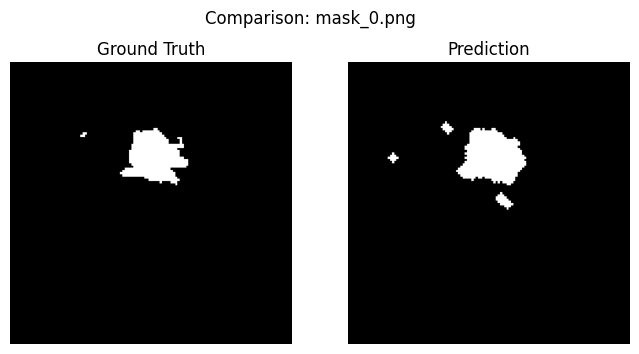

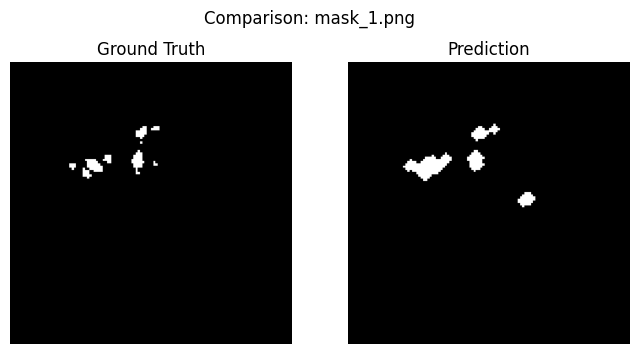

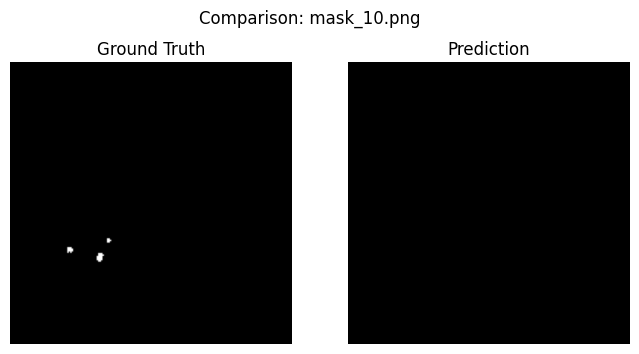

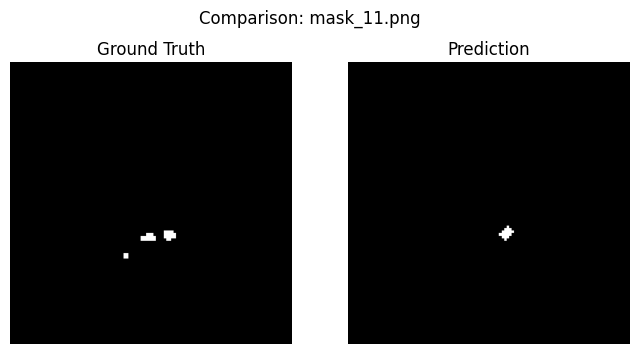

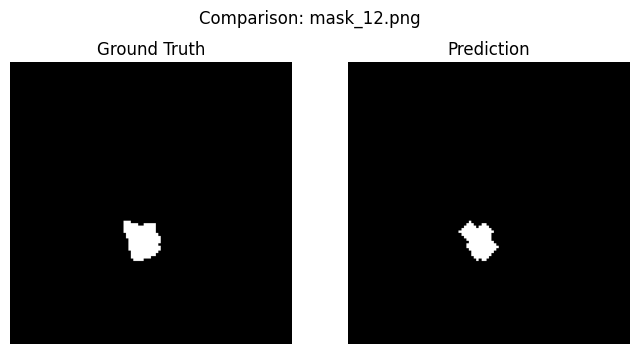

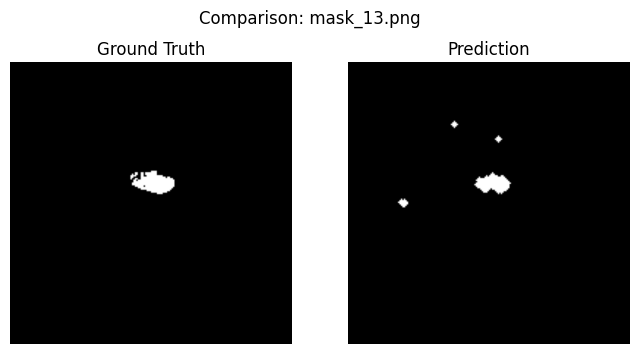

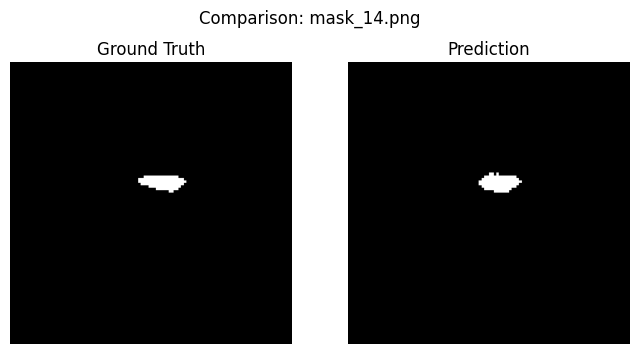

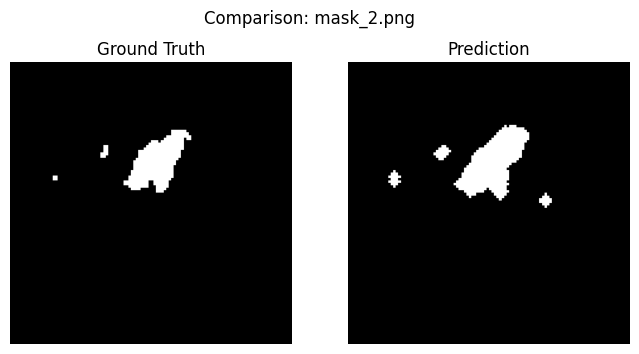

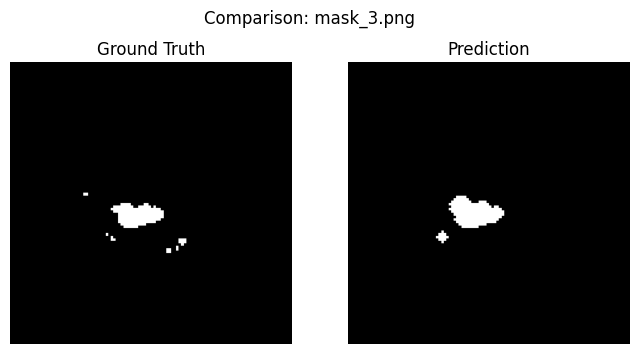

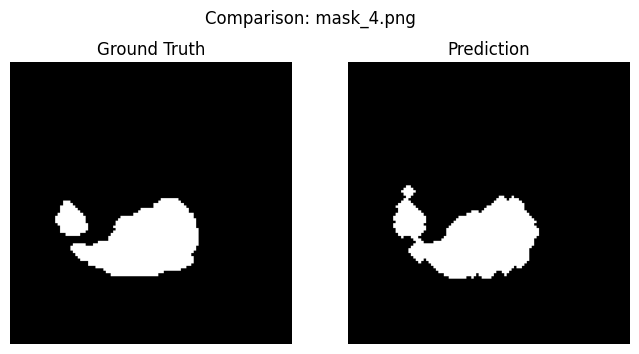

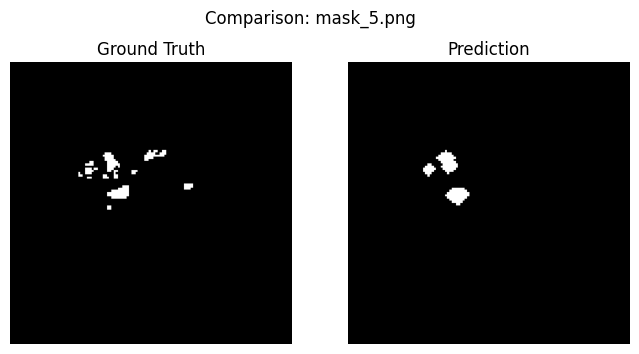

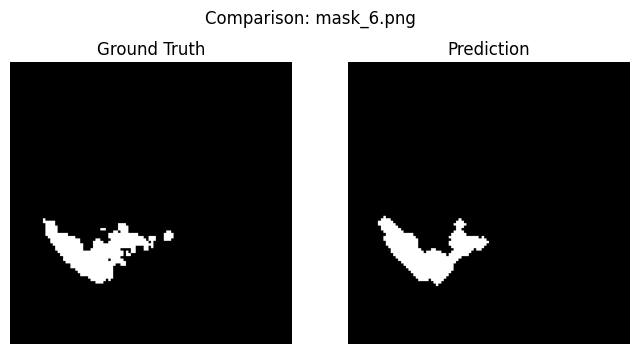

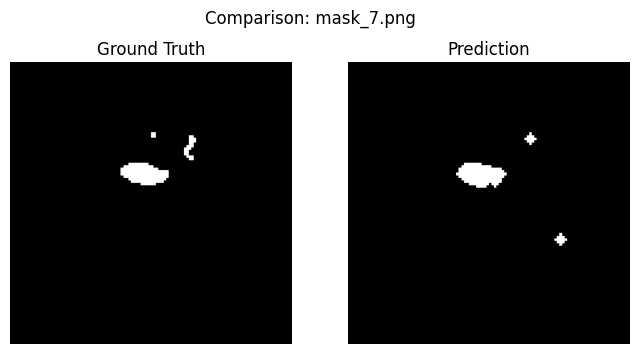

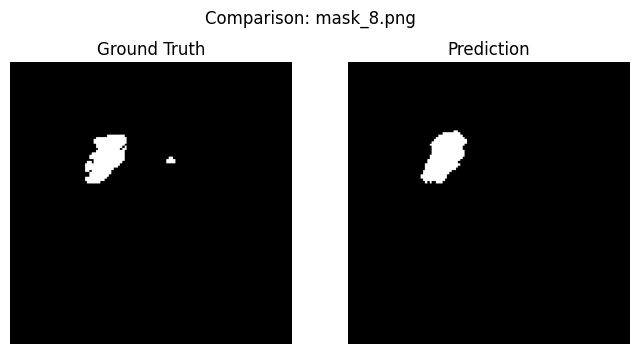

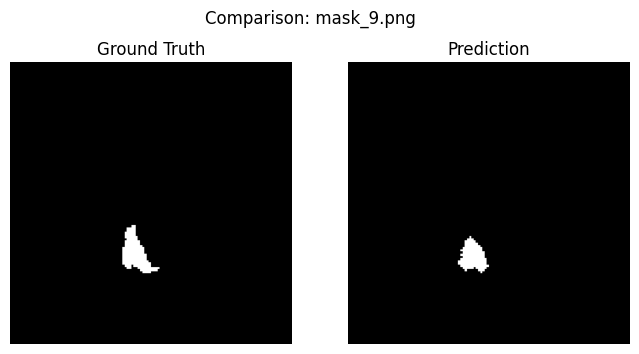

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Paths to your folders
pred_folder = "/content/drive/MyDrive/predicted"
gt_folder = "/content/drive/MyDrive/Ground_truth"

# Get sorted list of files (so corresponding files match)
pred_files = sorted(os.listdir(pred_folder))
gt_files = sorted(os.listdir(gt_folder))

# Loop through files
for pred_file, gt_file in zip(pred_files, gt_files):
    # Load images
    pred_img = Image.open(os.path.join(pred_folder, pred_file))
    gt_img = Image.open(os.path.join(gt_folder, gt_file))

    # Plot side by side
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(gt_img, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_img, cmap="gray")
    plt.title("Prediction")
    plt.axis("off")

    plt.suptitle(f"Comparison: {gt_file}")
    plt.show()
